# Toxic Comment Classifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Dataset

In [ ]:
# dataset link - https://drive.google.com/file/d/1qoObuKv9CyxL6mbvjvwBF_3BXPYHlBpy/view?usp=sharing

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Important Stuff(not really)/ML Project Repository/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Info of dataset
print("No of records - ", df.shape[0])
print()
df.info()

No of records -  159571

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### Data Analysis

In [ ]:
# check for rows without any lable (+ve comments)
no_label_count = 0
rowSum = df.iloc[:, 2:].sum(axis = 1)

for i in rowSum:
  if i == 0:
    no_label_count += 1

print("Total number of rows = ", df.shape[0])
print("No. of rows without lable(+ve comments) = ", no_label_count)

Total number of rows =  159571
No. of rows without lable(+ve comments) =  143346


<ipython-input-10-02bcd4668e1a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = x,y = y, alpha = 0.8, palette= ['blue', 'orange', 'red', 'green', 'violet', 'brown'])


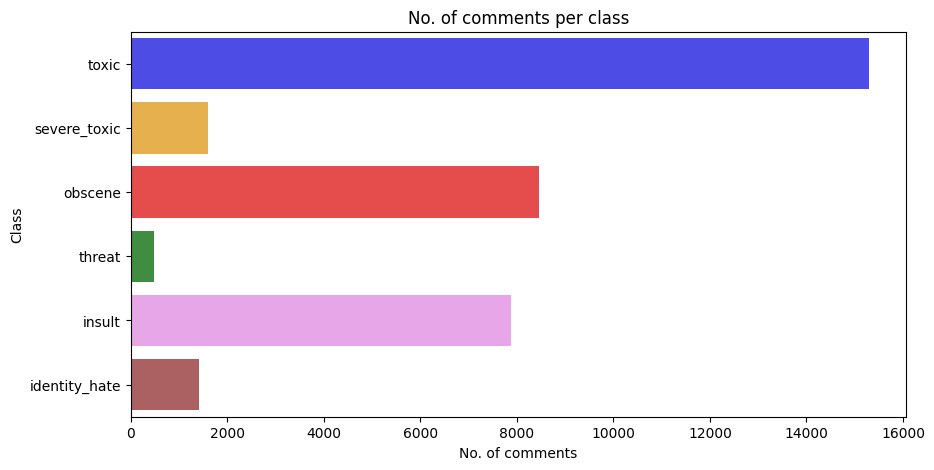

In [ ]:
# Plot
x = df.iloc[:,2:].sum()
y = df.columns[2:]

plt.figure(figsize = (10, 5))
sns.barplot(x = x,y = y, alpha = 0.8, palette= ['blue', 'orange', 'red', 'green', 'violet', 'brown'])
plt.title("No. of comments per class")
plt.xlabel("No. of comments")
plt.ylabel("Class")
plt.show()

### Data Preprocessing

In [ ]:
# check for null values and remove unwanted data
no_of_NaN = df.isnull().sum()
print(no_of_NaN)

df.drop(['id'], axis = 1, inplace = True)
df.dropna(inplace = True)


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
# Text cleaning and Stopword removal
stopwords = stopwords.words('english')

def clean_text(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"don't","do not", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\W", " ", text)
  text = re.sub(r"\s+", " ", text)
  return text


def remove_stopwords(text):
  no_stop_words = []

  for w in text.split():
    if w not in stopwords:
      no_stop_words.append(w)

  return ' '.join(no_stop_words)



In [ ]:
# Stemming
stemmer = SnowballStemmer('english')

def stemming(text):
  stemmed_words = []

  for w in text.split():
    w = stemmer.stem(w)
    stemmed_words.append(w)

  return ' '.join(stemmed_words)


In [ ]:
# Preprocess the comments
df['comment_text'] = df['comment_text'].apply(clean_text)
df['comment_text'] = df['comment_text'].apply(remove_stopwords)
df['comment_text'] = df['comment_text'].apply(stemming)

df['comment_text'][:5]

,comment_text
0,explan edit made usernam hardcor metallica fan...
1,aww match background colour seem stuck thank t...
2,hey man realli tri edit war guy constant remov...
3,make real suggest improv wonder section statis...
4,sir hero chanc rememb page


### Model Training

In [ ]:
X = df["comment_text"]
Y = df.drop(['comment_text'], axis = 1)

# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [ ]:
# Make Pipelines
LR_pipeline = Pipeline([
                        ('tfidf', TfidfVectorizer(stop_words = 'english')),
                        ('lr_model', OneVsRestClassifier(LogisticRegression(), n_jobs = -1))
])


In [ ]:
def run_pipeline(model, x_train, x_test, y_train, y_test):

  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)

  # check accuracy
  print("Accuracy Score = ", accuracy_score(y_test, y_pred))
  print()
  print("Classification Report :-\n", classification_report(y_test, y_pred))

In [ ]:
run_pipeline(LR_pipeline, X_train, X_test, Y_train, Y_test)

Accuracy Score =  0.918314272285759

Classification Report :-
               precision    recall  f1-score   support

           0       0.91      0.62      0.74      3056
           1       0.61      0.28      0.38       321
           2       0.91      0.64      0.75      1715
           3       0.67      0.14      0.22        74
           4       0.81      0.51      0.62      1614
           5       0.69      0.16      0.26       294

   micro avg       0.87      0.56      0.68      7074
   macro avg       0.77      0.39      0.50      7074
weighted avg       0.86      0.56      0.67      7074
 samples avg       0.06      0.05      0.05      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Detoxifing Text

In [ ]:
import os
import google.generativeai as genai

def detoxify_comment(comment):
  genai.configure(api_key="YOUR_API_KEY")

  # Create the model
  generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
  }

  model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=generation_config,
  )

  chat_session = model.start_chat(
    history=[]
  )

  response = chat_session.send_message(f"give me a direct answer for little less rude version of : '{comment}' and if you can't just return 'Too offensive, can't detoxify' ")

  return response.text


### Model Testing and Results

In [ ]:
label = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
def prediction(comment):
  ori_text = comment
  comment = clean_text(comment)
  comment = remove_stopwords(comment)
  comment = stemming(comment)

  predicted_value = LR_pipeline.predict([comment])[0]

  for i in range(6):
    print( "%14s %5s" % (label[i], predicted_value[i]))

  print()
  if any(predicted_value):
    new_text = detoxify_comment(ori_text)

    print("Original Comment : ", ori_text )
    print("Detoxified Comment : ", new_text)

  else:
    print("This comment is Non-Toxic :)")

In [ ]:
# Change comment and see results

# Some example test cases for each catagory
toxic = "You are such a disgrace"
severe_toxic = "Don't fuck around here"
obscene = "Stupid piece of shit"
threat = "I will kill you"
insult = "He is such a loser, no one wants to be around him"
identity_hate = "You are gay?"

# Use above examples or any sentence of your choice :)
comment = "you are such an idiot"

prediction(comment)

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0

Original Comment :  you are such an idiot
Detoxified Comment :  "I think you may have misunderstood something."

